In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style="darkgrid")
import lightgbm as lgb
import shap
from sklearn.metrics import mean_squared_error, r2_score

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False  

In [12]:
df = pd.read_csv(r"D:\TencentFiles\kc_house_data.csv")

In [13]:
print(df.sample(5))

               id             date      price  bedrooms  bathrooms  \
2601   2464400340  20140625T000000   381500.0         2        1.0   
5961   8155800050  20150422T000000  1110000.0         3        4.0   
16029  9264030470  20140611T000000   455000.0         4        2.5   
7430   9510970050  20140901T000000   583000.0         4        2.5   
2895    423059184  20141201T000000   180000.0         3        1.0   

       sqft_living  sqft_lot  floors  waterfront  view  ...  grade  \
2601           900      2910     1.0           0     0  ...      7   
5961          4160     31796     2.0           0     0  ...     11   
16029         3170     10688     2.0           0     2  ...      9   
7430          1840      4011     2.0           0     0  ...      9   
2895          1960      9583     2.0           0     0  ...      5   

       sqft_above  sqft_basement  yr_built  yr_renovated  zipcode      lat  \
2601          900              0      1924             0    98115  47.6859   
59

In [14]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [15]:
print(df.describe())

                 id         price      bedrooms     bathrooms   sqft_living  \
count  2.161300e+04  2.161300e+04  21613.000000  21613.000000  21613.000000   
mean   4.580302e+09  5.400881e+05      3.370842      2.114757   2079.899736   
std    2.876566e+09  3.671272e+05      0.930062      0.770163    918.440897   
min    1.000102e+06  7.500000e+04      0.000000      0.000000    290.000000   
25%    2.123049e+09  3.219500e+05      3.000000      1.750000   1427.000000   
50%    3.904930e+09  4.500000e+05      3.000000      2.250000   1910.000000   
75%    7.308900e+09  6.450000e+05      4.000000      2.500000   2550.000000   
max    9.900000e+09  7.700000e+06     33.000000      8.000000  13540.000000   

           sqft_lot        floors    waterfront          view     condition  \
count  2.161300e+04  21613.000000  21613.000000  21613.000000  21613.000000   
mean   1.510697e+04      1.494309      0.007542      0.234303      3.409430   
std    4.142051e+04      0.539989      0.086517    

In [16]:
print(df.isnull().any())

id               False
date             False
price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
view             False
condition        False
grade            False
sqft_above       False
sqft_basement    False
yr_built         False
yr_renovated     False
zipcode          False
lat              False
long             False
sqft_living15    False
sqft_lot15       False
dtype: bool


In [17]:
# 1. 创建新特征
df['house_age'] = 2024 - df['yr_built']  # 计算房龄
df['renovated'] = np.where(df['yr_renovated'] > 0, 1, 0)  # 是否翻新
df['living_density'] = df['sqft_living'] / df['sqft_lot']  # 生活密度
df['location_score'] = (df['lat'] * 100) + df['long']  # 地理位置评分

# 2. 处理偏斜特征
df['log_price'] = np.log1p(df['price'])  # 对数转换目标变量
df['log_sqft_lot15'] = np.log1p(df['sqft_lot15'])

# 3. 特征选择
features = ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 
           'view', 'condition', 'grade', 'sqft_above', 'sqft_basement',
           'house_age', 'renovated', 'living_density', 'location_score',
           'log_sqft_lot15', 'zipcode']

X = df[features]
y = df['log_price']  # 使用对数转换后的价格

# 4. 数据集拆分
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [18]:
# ================== LightGBM模型训练 ==================
# 创建数据集
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# 设置参数
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# 训练模型
model_lgb = lgb.train(params,
                   train_data,
                   num_boost_round=1000,
                   valid_sets=[test_data],
                   callbacks=[lgb.early_stopping(stopping_rounds=50)])

# 预测与评估
y_pred_lgb = model_lgb.predict(X_test)
rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_lgb)))
r2 = r2_score(np.expm1(y_test), np.expm1(y_pred_lgb))
print(f"LightGBM RMSE: {rmse:.2f}")
print(f"LightGBM R²: {r2:.4f}")

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[462]	valid_0's rmse: 0.167679
LightGBM RMSE: 128920.46
LightGBM R²: 0.8901


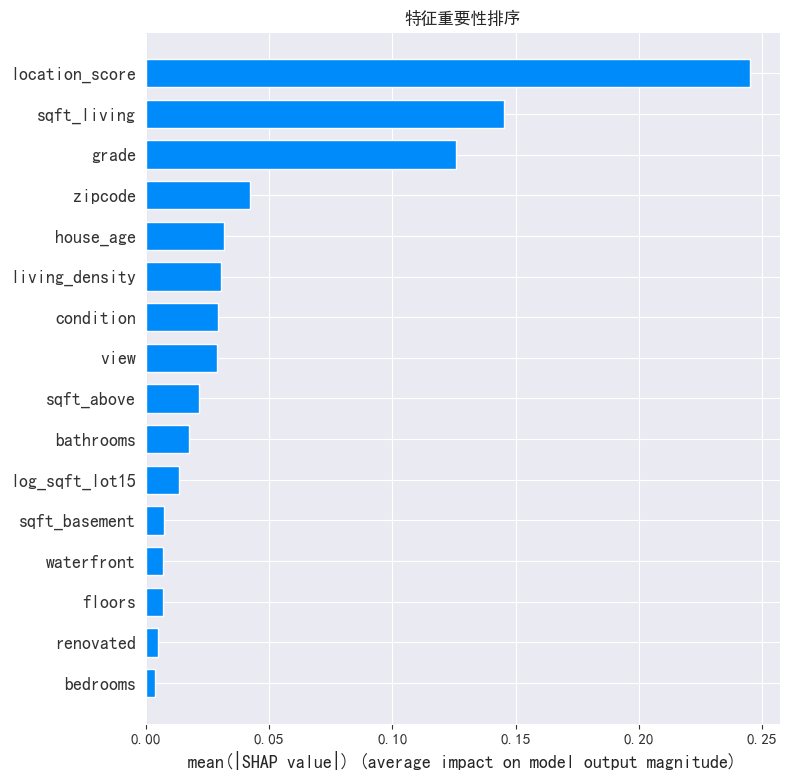

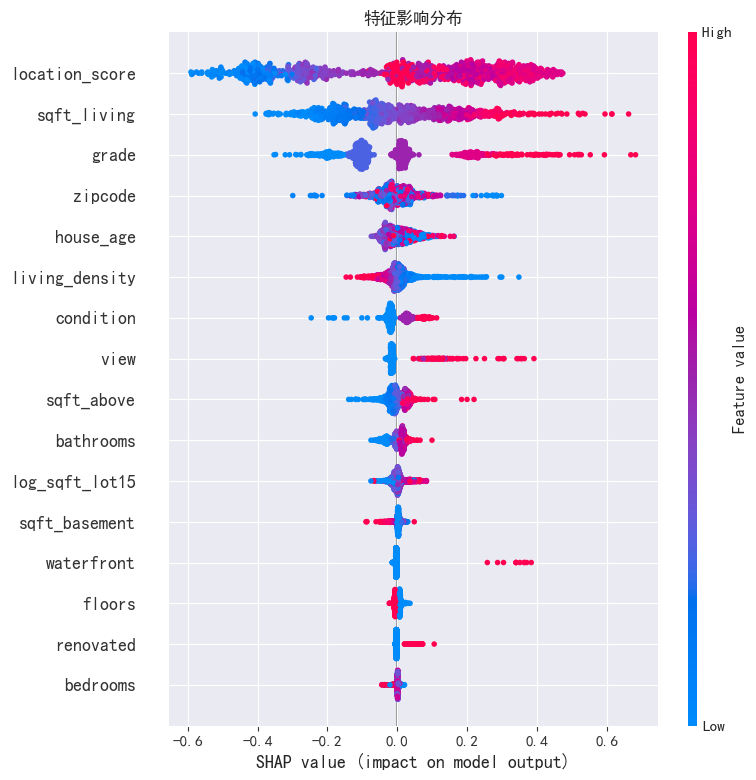

<Figure size 1000x400 with 0 Axes>

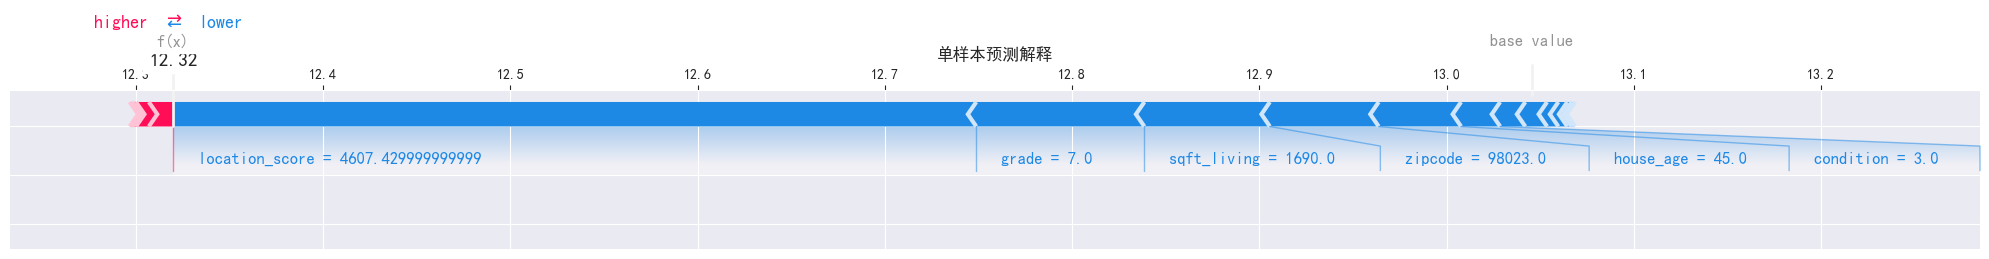

SHAP分析图表已保存到 media/ 目录


In [19]:
# ================== SHAP可解释性分析 ==================
# 初始化SHAP解释器
explainer = shap.TreeExplainer(model_lgb)

# 计算SHAP值（对测试集采样以加快计算）
X_test_sampled = X_test.sample(1000, random_state=42)
shap_values = explainer.shap_values(X_test_sampled)

# 创建保存图片的目录
import os
os.makedirs('media', exist_ok=True)

# 1. 特征重要性全局分析
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_sampled, plot_type="bar", show=False)
plt.title("特征重要性排序")  # 替换为你的姓名
plt.tight_layout()
plt.savefig('media/feature_importance.png', dpi=300)
plt.show()

# 2. 特征影响方向分析
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_sampled, show=False)
plt.title("特征影响分布")  # 替换为你的姓名
plt.tight_layout()
plt.savefig('media/feature_impact.png', dpi=300)
plt.show()

# 3. 单个预测解释
plt.figure(figsize=(10, 4))
shap.force_plot(explainer.expected_value, 
                shap_values[0], 
                X_test_sampled.iloc[0],
                matplotlib=True,
                show=False)
plt.title("单样本预测解释")  # 替换为你的姓名
plt.tight_layout()
plt.savefig('media/individual_prediction.png', dpi=300)
plt.show()

print("SHAP分析图表已保存到 media/ 目录")

In [20]:
x_vars=df.columns[3:]
for x_var in x_vars:
   df.plot(kind='scatter',x=x_var,y='price')

c:\Users\moyaj\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\plotting\_matplotlib\core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


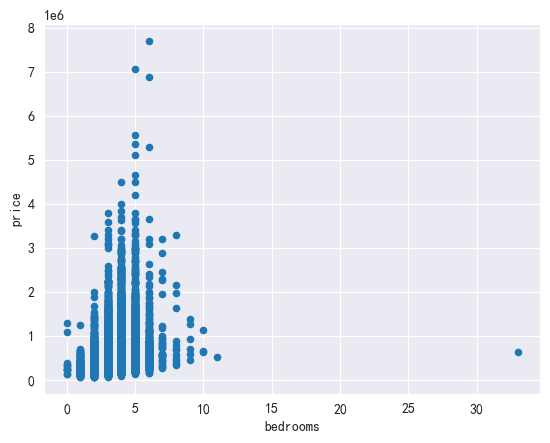

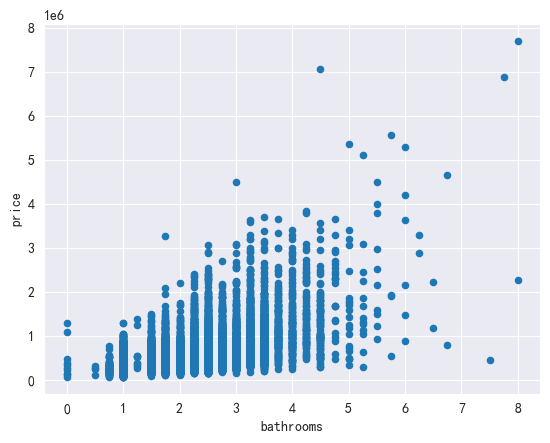

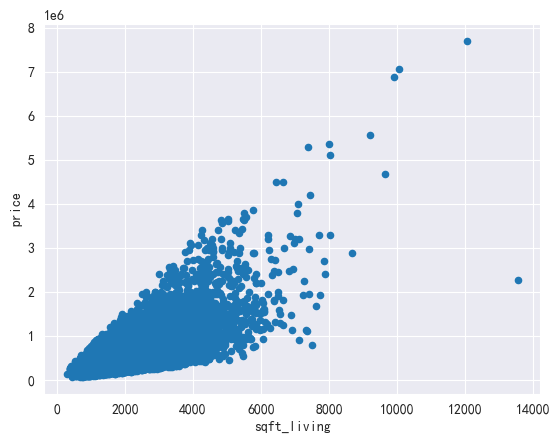

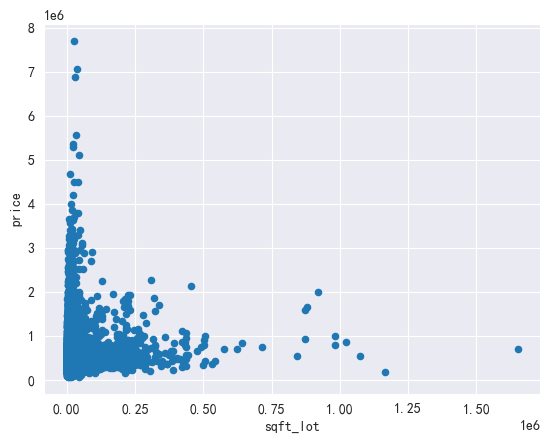

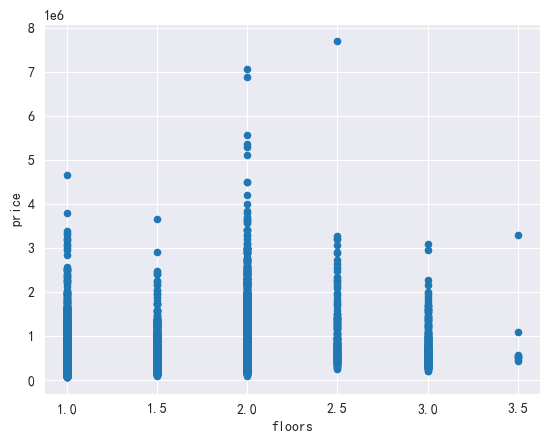

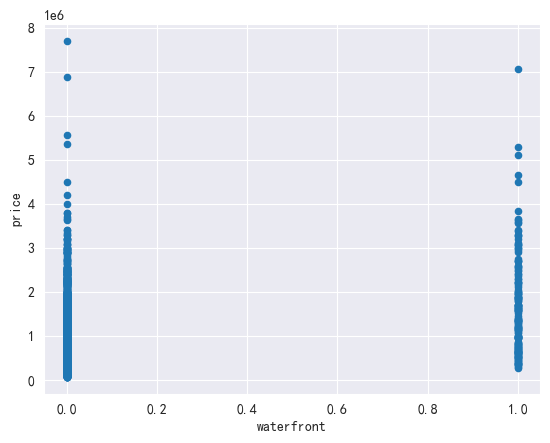

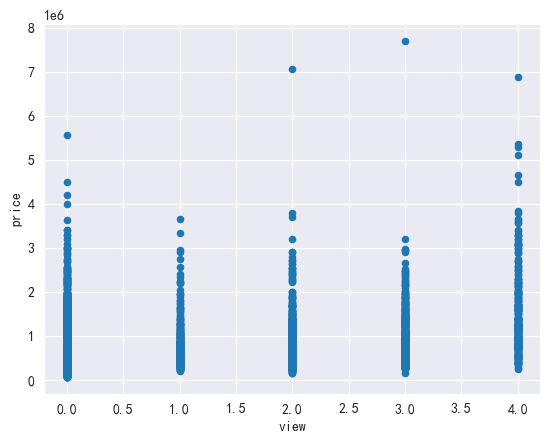

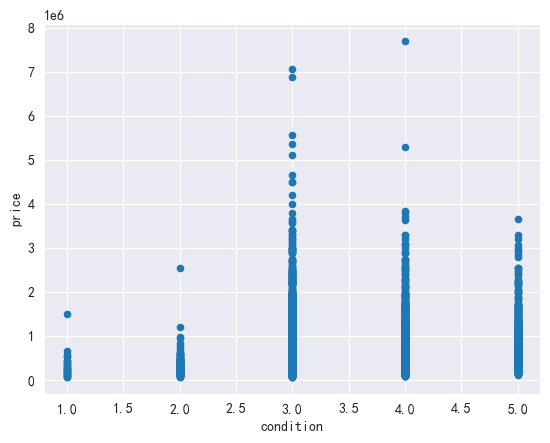

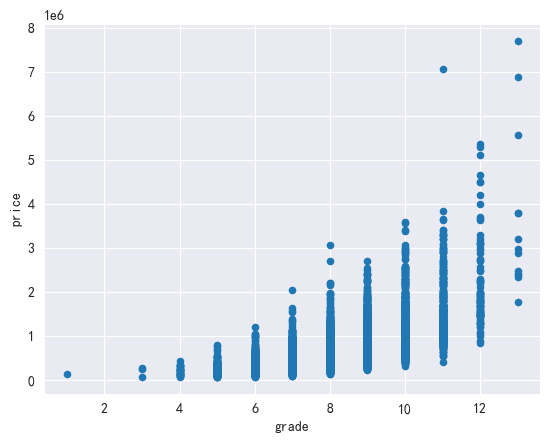

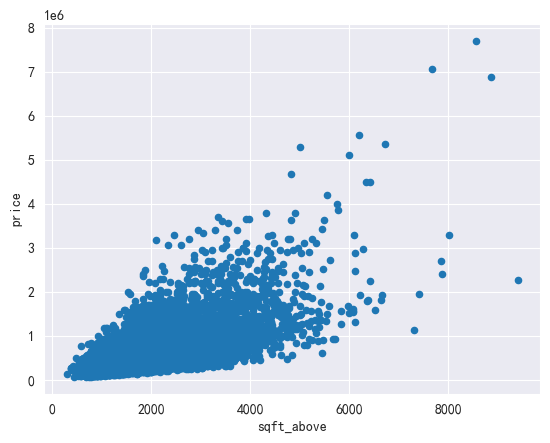

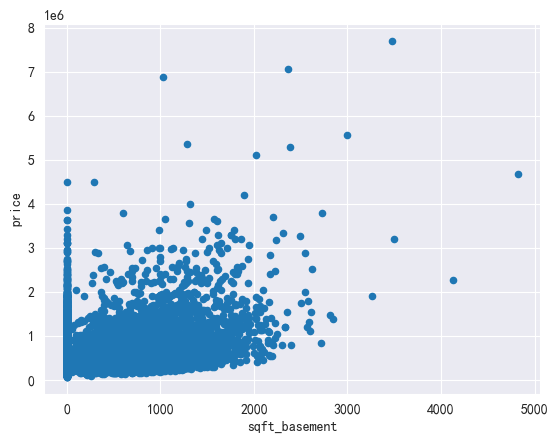

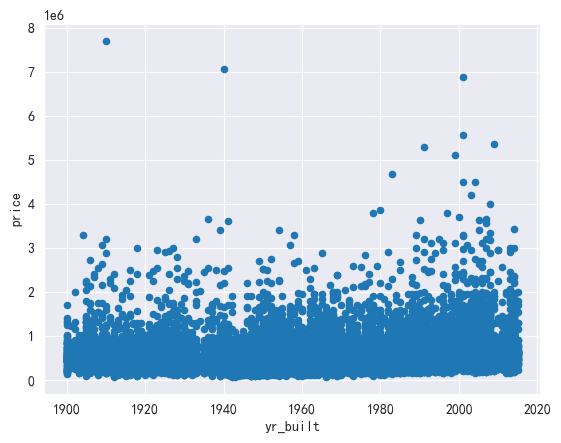

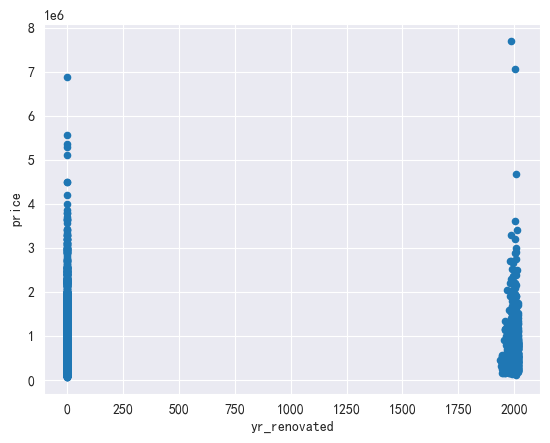

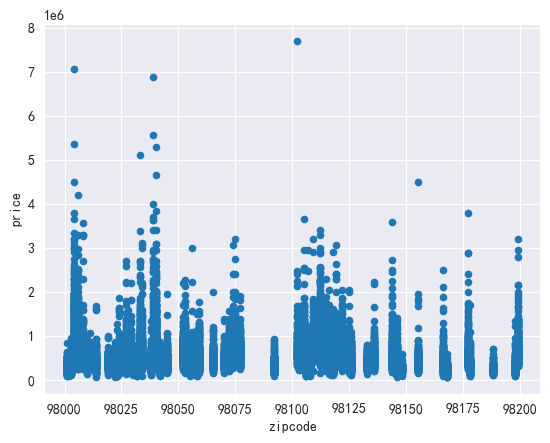

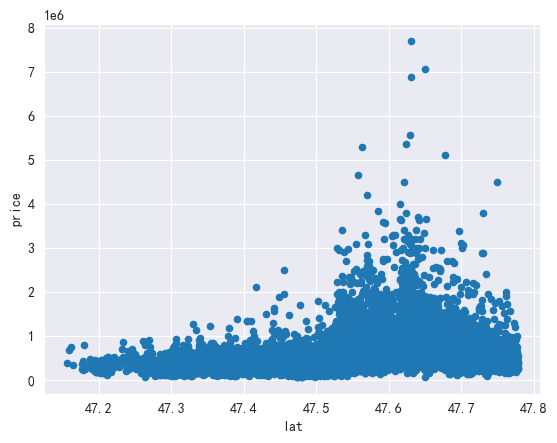

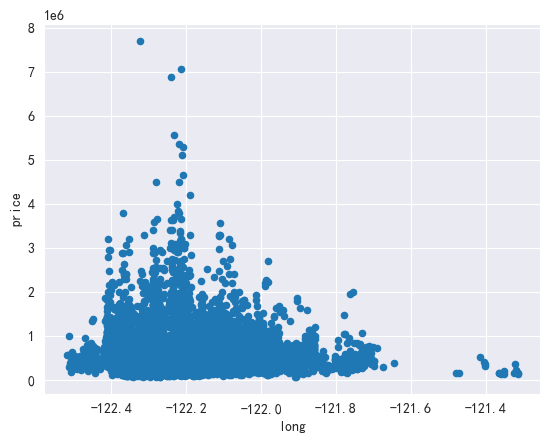

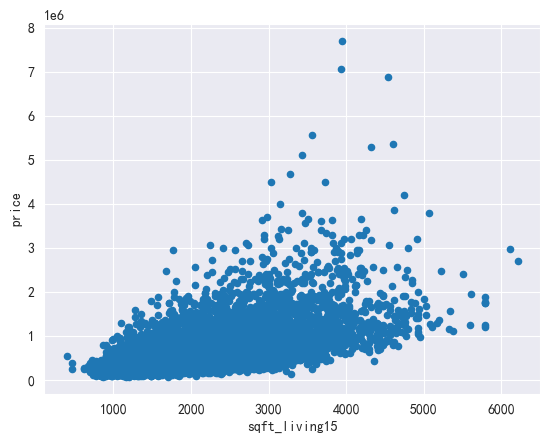

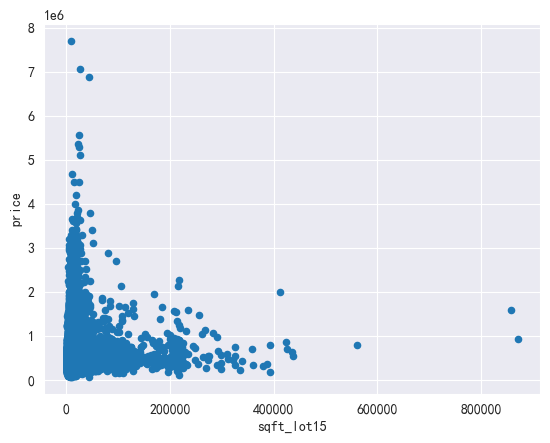

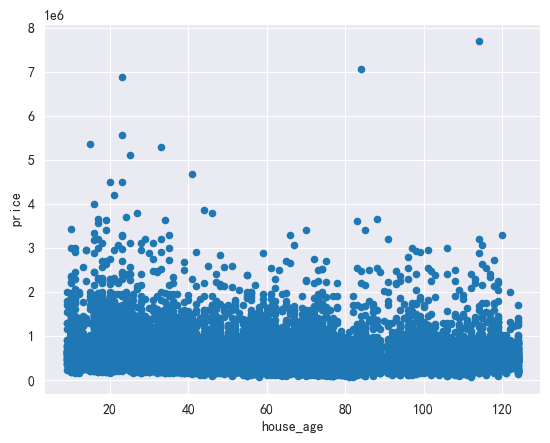

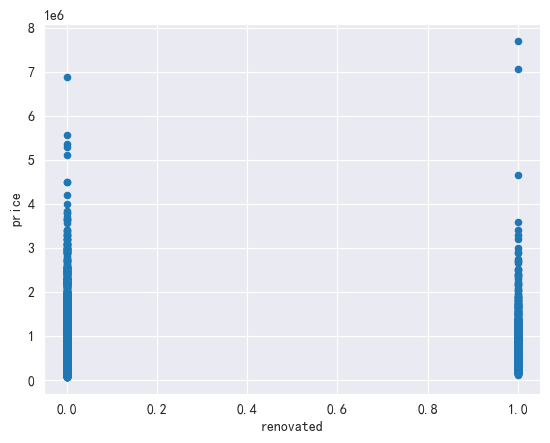

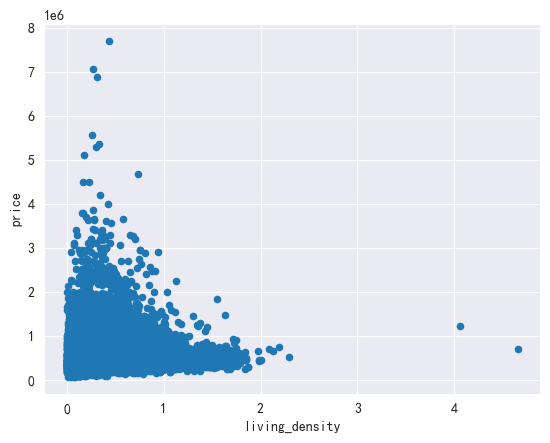

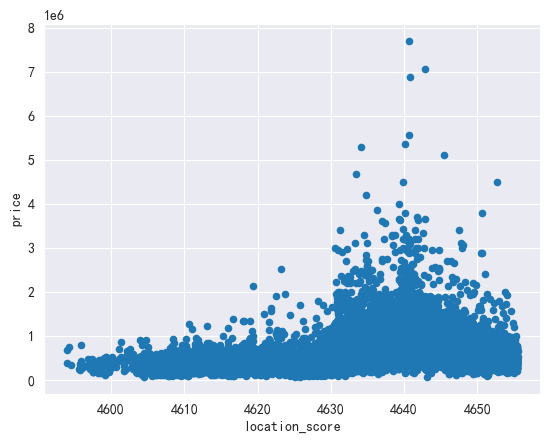

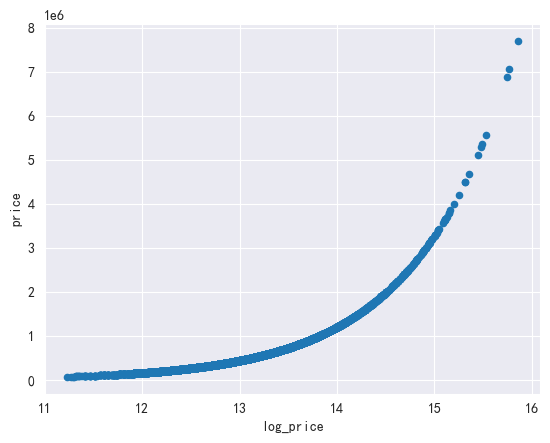

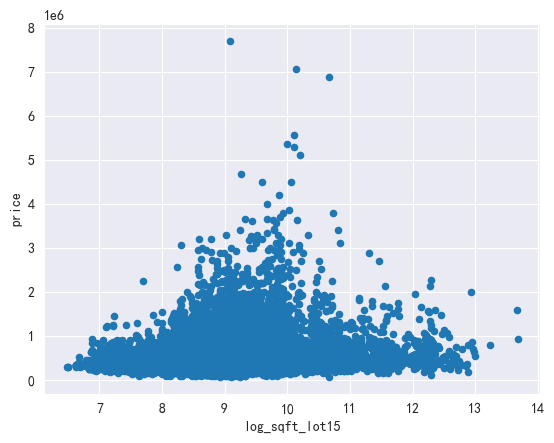

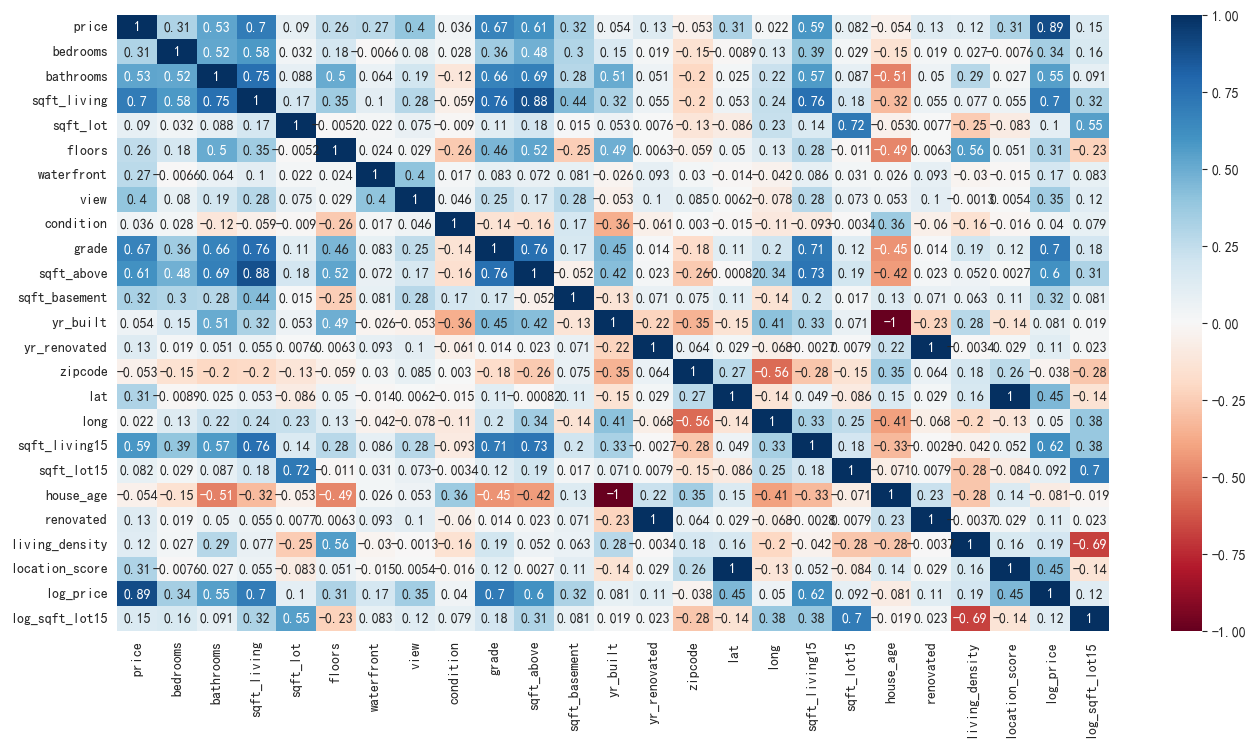

In [21]:
# 删除原始数据中的索引id
df.drop(["id"], axis=1, inplace=True)

# 仅选择数值列或确保所有列都是数值型
numeric_df = df.select_dtypes(include=['number'])

# 计算属性间的相关系数图
corr = numeric_df.corr()

# 绘制属性相关系数的热力图
plt.figure(figsize=(16, 8))
sns.heatmap(corr, annot=True, cmap="RdBu")
plt.show()

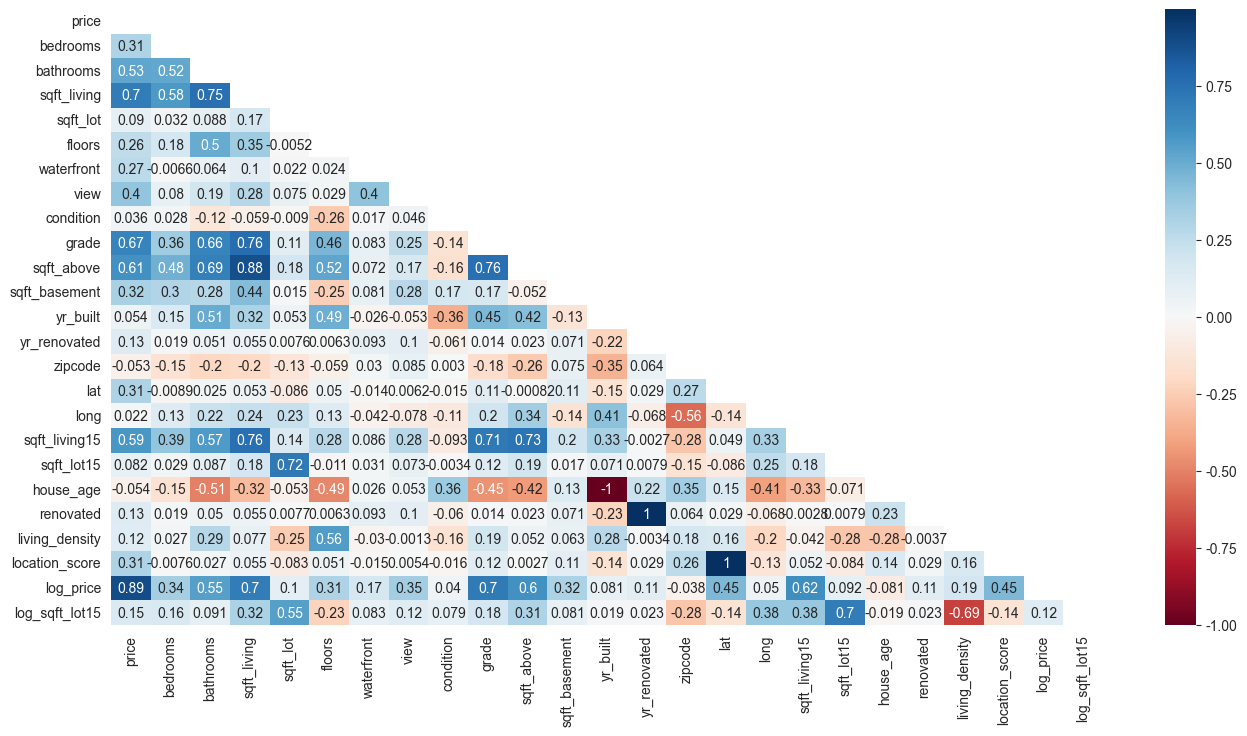

In [22]:
plt.figure(figsize=(16,8))
mask = np.zeros_like(corr,dtype=np.bool)
# Create a msk to draw only lower diagonal corr map
mask[np.triu_indices_from(mask)] = True
sns.set_style(style="white")
sns.heatmap(corr,annot=True,cmap="RdBu",mask=mask)
plt.show ()


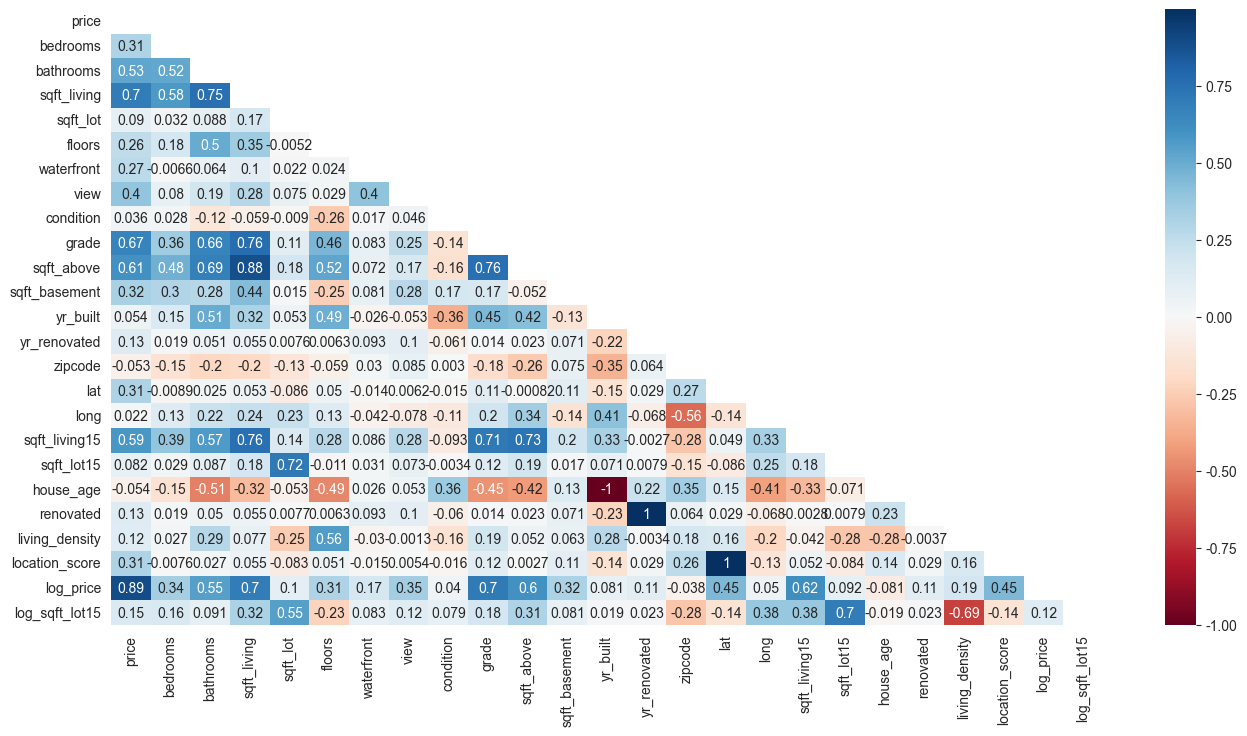

In [23]:
plt.figure(figsize=(16,8))
mask = np.zeros_like(corr,dtype=np.bool)
# Create a msk to draw only lower diagonal corr map
mask[np.triu_indices_from(mask)] = True
sns.set_style(style="white")
sns.heatmap(corr,annot=True,cmap="RdBu",mask=mask)
plt.show ()



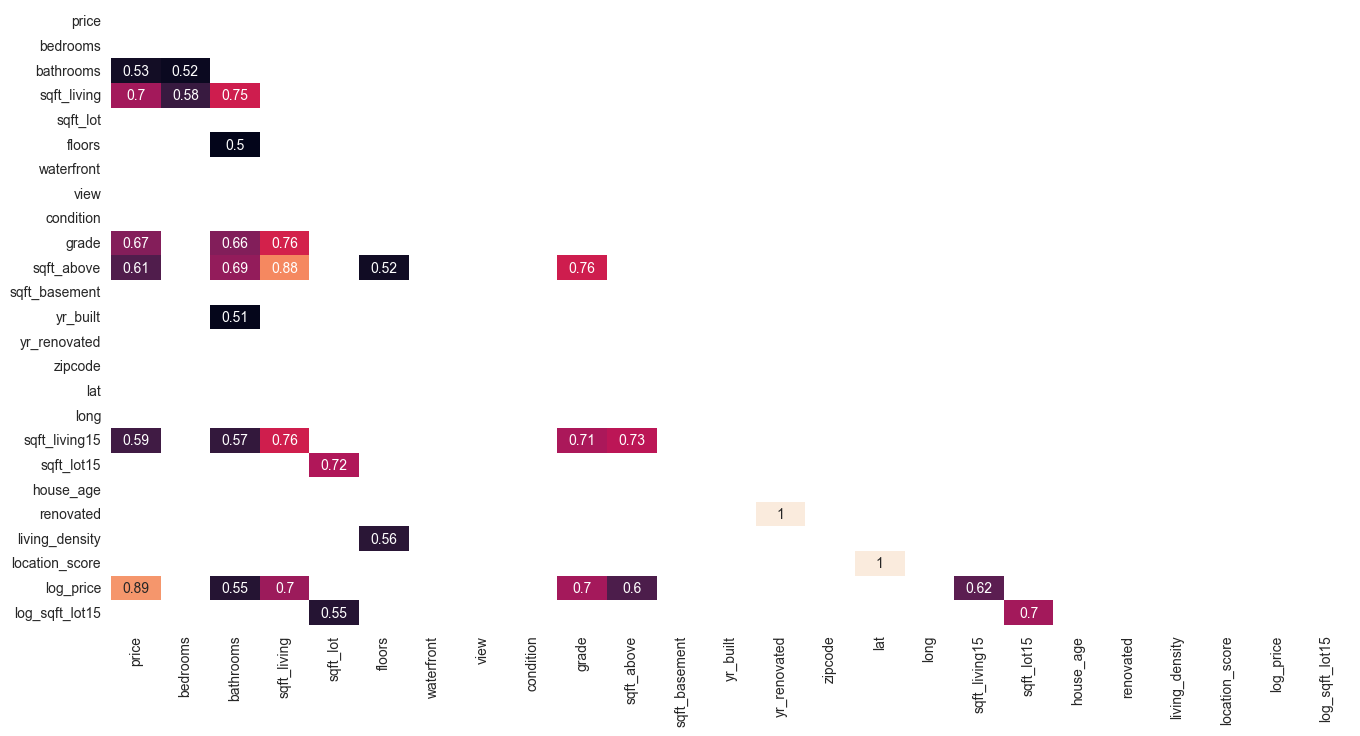

In [24]:
plt.figure(figsize=(16,8))
mask = np.zeros_like(corr[corr>=.5],dtype=np.bool)

# Create a msk to draw only lower diagonal corr map
mask[np.triu_indices_from(mask)] = True
sns.set_style(style="white")
sns.heatmap(corr[corr>=.5],annot=True,mask=mask,cbar=False)
plt.show()


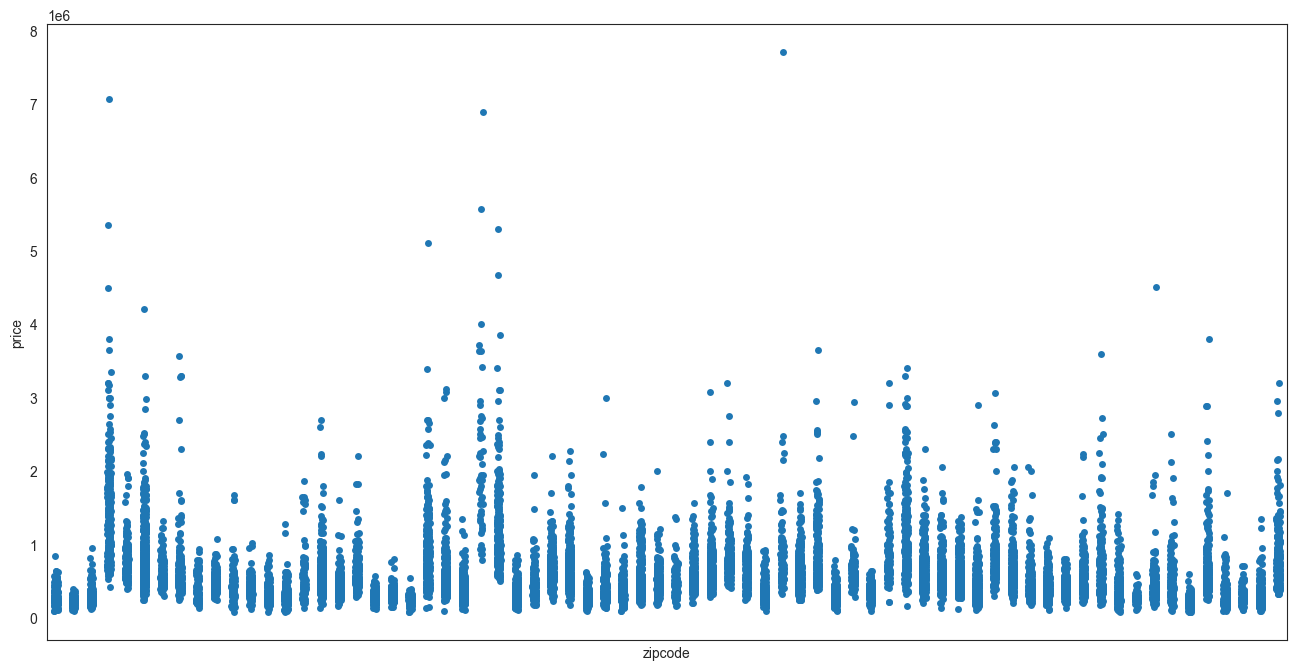

In [25]:
plt.figure(figsize=(16,8))
sns.stripplot(x="zipcode", y="price", data=df, jitter=True) 
plt.xticks([])
plt.show()

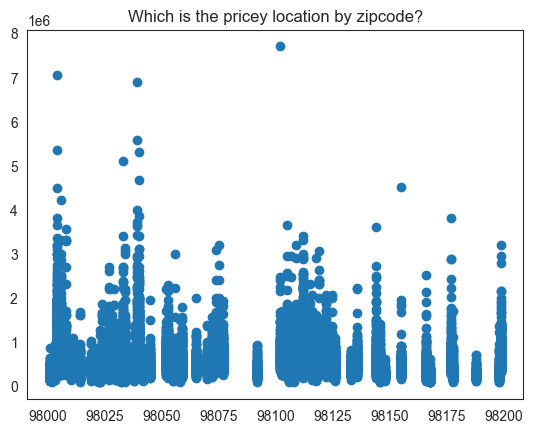

In [26]:
plt.scatter(df.zipcode,df.price)
plt.title("Which is the pricey location by zipcode?")
plt.show()


In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# 选择特征列（推荐使用 .values 或直接 DataFrame 列名列表）
features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 
            'waterfront', 'view', 'condition', 'grade', 'sqft_above', 
            'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
            'lat', 'long', 'sqft_living15', 'sqft_lot15']

X = df[features].values  # 替代已弃用的 .as_matrix()
y = df['price']

# 拆分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=10
)

# 训练线性回归模型
model = LinearRegression()
model.fit(X_train, y_train)

# 评估模型
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
print(f"Train R²: {train_score:.4f}, Test R²: {test_score:.4f}")


Train R²: 0.6945, Test R²: 0.7098


In [28]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train= sc.transform(X_train)
X_test = sc.transform(X_test)

In [29]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)
#let us predict
y_pred=model.predict(X_test)
print (model.score(X_test, y_test ))

0.7097660077351816


In [30]:
from sklearn.ensemble import RandomForestRegressor 
model = RandomForestRegressor(n_estimators=500)
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
print (model.score(X_test, y_test))

0.8777865462736385


In [31]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(n_estimators=500)
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
print (model.score(X_test, y_test))



0.8846181389863239


In [32]:
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor(n_neighbors=10)
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
print (model.score(X_test, y_test))


0.7916054668753373


In [33]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
print (model.score(X_test, y_test))


0.7322520385421452


In [34]:
model = GradientBoostingRegressor(n_estimators=500)
model.fit(X_train, y_train)
y_predicted = model.predict(X)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print(mean_absolute_error(y,y_predicted))
print(mean_squared_error(y,y_predicted))
print(r2_score(y,y_predicted))


4735200.893241587
22623993678402.234
-166.86349056153307


In [35]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV  # 更新导入路径

# 初始化模型
model_gbr = GradientBoostingRegressor()

# 定义参数网格
parameters = {
    'loss': ['ls', 'lad', 'huber', 'quantile'],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'alpha': [0.1, 0.3, 0.6, 0.9]
}

# 使用 GridSearchCV 进行超参数调优
model_gs = GridSearchCV(
    estimator=model_gbr,
    param_grid=parameters,
    cv=5,  # 5折交叉验证
    scoring='neg_mean_squared_error',  # 可选：指定评估指标
    n_jobs=-1  # 并行计算（使用所有CPU核心）
)

# 拟合模型
model_gs.fit(X, y)

# 输出最佳参数和最佳得分
print('Best score (negative MSE):', model_gs.best_score_)
print('Best parameters:', model_gs.best_params_)

c:\Users\moyaj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
200 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\moyaj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\moyaj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\moyaj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.p

Best score (negative MSE): -20750948610.72096
Best parameters: {'alpha': 0.9, 'loss': 'huber', 'min_samples_leaf': 4}


In [36]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 初始化模型（使用正确的 loss 参数）
model = GradientBoostingRegressor(
    n_estimators=500,
    loss='squared_error',  # 替代 'ls'，表示最小二乘回归
    min_samples_leaf=2,
    random_state=42,       # 确保可复现性
    verbose=1             # 显示训练进度
)

# 训练模型
model.fit(X_train, y_train)

# 预测测试集
y_pred = model.predict(X_test)

# 计算评估指标
print("R² Score:", model.score(X_test, y_test))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R² (via r2_score):", r2_score(y_test, y_pred))

      Iter       Train Loss   Remaining Time 
         1 117946819056.2835           14.57s
         2 104847541188.4715           14.73s
         3 94152225160.2862           14.39s
         4 84812085023.6119           14.74s
         5 76988511245.5442           14.60s
         6 70385853481.6322           14.62s
         7 64626078953.4457           14.86s
         8 59617523873.2157           14.71s
         9 55461698780.2272           14.85s
        10 51723423221.0656           14.97s
        20 31291611957.0449           14.17s
        30 23503670543.9523           13.96s
        40 19810489854.6822           13.74s
        50 17692290646.2392           13.41s
        60 16404053977.3370           13.08s
        70 15416247723.2833           12.77s
        80 14671027580.7034           12.44s
        90 14129479612.5858           12.15s
       100 13698709922.0150           11.90s
       200 10763051262.7550            8.85s
       300  9254461122.2268            5.87s
       

In [37]:
model = GradientBoostingRegressor(n_estimators=500)
model.fit(X_train, y_train)
y_predicted = model.predict(X)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print(mean_absolute_error(y,y_predicted))
print(mean_squared_error(y,y_predicted))
print(r2_score(y,y_predicted))


4862454.448408334
23849069676756.4
-175.95320019503612


In [ ]:
model_gbr = GradientBoostingRegressor()
from sklearn.model_selection import GridSearchCV
# from sklearn.grid_search import GridSearchCV  //旧版scikit-learn代码
parameters = {'loss': ['ls','lad','huber','quantile'],'min_samples_leaf': [1,2,3,4,5],'alpha': [0.1,0.3,0.6,0.9]}
model_gs = GridSearchCV(estimator=model_gbr, param_grid=parameters, cv=5)
model_gs.fit(X,y)
print('Best score is:', model_gs.best_score_)
print('Best parameter is:', model_gs.best_params_)

c:\Users\moyaj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
200 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\moyaj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\moyaj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\moyaj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base

Best score is: 0.8474167879617134
Best parameter is: {'alpha': 0.9, 'loss': 'huber', 'min_samples_leaf': 5}


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
# model = GradientBoostingRegressor(n_estimators=500,alpha=0.3,loss='ls',min_samples_leaf=2)  //旧版scikit-learn代码
model = GradientBoostingRegressor(n_estimators=500, alpha=0.3, loss='squared_error', min_samples_leaf=2)
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print(model.score(X_test, y_test))
print(mean_absolute_error(y_test,y_pred))
print(mean_squared_error(y_test,y_pred))
print(r2_score(y_test,y_pred))

0.8890674294563012
67649.90400403558
15301307262.698084
0.8890674294563012


In [42]:
# 导入必要的库
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D

# df 是我们读取的原始数据
# 特征和标签的准备工作：
# 请确保你已经加载了数据并进行了适当的预处理
# 示例数据加载代码：
# df = pd.read_csv('your_data.csv')

# 假设特征列和目标列
feature_columns = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
X = df[feature_columns].values
y = df['price'].values

# 数据集拆分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

# 数据标准化
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# 将数据转换为适合 CNN 输入的形式
X_train_cnn = np.expand_dims(X_train_std, axis=2)  # 增加通道维度
X_test_cnn = np.expand_dims(X_test_std, axis=2)

# 构建 CNN 模型
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_cnn.shape[1], 1)))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(100, activation='relu'))
model_cnn.add(Dense(1))  # 回归问题，输出层没有激活函数

# 编译模型
model_cnn.compile(optimizer='adam', loss='mse')  # 房价预测是回归问题，使用均方误差损失函数

# 训练模型
model_cnn.fit(X_train_cnn, y_train, epochs=100, batch_size=32, verbose=1)

# 模型评估
loss = model_cnn.evaluate(X_test_cnn, y_test, verbose=0)
print(f"Test Loss (MSE): {loss}")

# 可以使用 model_cnn.predict(X_test_cnn) 来进行预测

KeyboardInterrupt: 